In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='d68c15ff-ad09-48d2-9cbd-69bbb0b9d241', project_access_token='p-350e2c0d97ed5321486c76b8ac2838698b92f857')
pc = project.project_context

# Streaming TimeSeries prediction using SPSS Flow deployed in WML

**(C) 2021 IBM - Philippe Gregoire - Ecosystem Advocacy Group Europe - Partners Technical Enablement**

## Prerequisites:
* A SPSS Flow with a Streaming Time Series node must be deployed to Watson Machine Learning
* An input file in CSV format with columns matching the deployed WML SPSS model must be present in Cloud Object Storage

## Operations
* We first load the CSV file from COS into a pandas DataFrame, `df_data`
* That dataframe is converted to an array of rows, each row itself being an array or individual values.
* We initialize the WML client with the WML credentials where that model is deployed.
* The array of timeseries values is fed into a WML prediction call
* The predictions are returned in JSON-formatted text
* We convert the text to JSON (Python dictionary) and then back to a Results DataFrame
* The predictions DataFrame is then stored in a new file in COS

## Notes
* Here we assume that the input CSV file has been created in COS from its DB2 data source tables, using a Data refinery flow that has joined the two
* We could also connect directly to the DB2 tables and build the dataframe from there rather than going through COS

### First step: Insert project token
From the vertical ellipsis button at the top right, select `Insert project token` 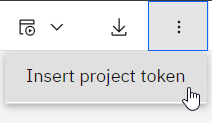

==> This creates a new code cell as the first cell in the notebook, scroll up from here and execute it

In [2]:
# test if we have a project context now
try:
    print(f"Project name: {project.get_name()}")
except:
    print("No project context, please insert project token and Run resulting cell")

Project name: Workshop_2021_PhG


### Upload the Deployment Space APIKey `json` file
* obtain an API Key from https://cloud.ibm.com/iam/apikeys
* Open the Add data panel from the menu at the top right 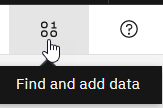
* Upload the `AccountAPIKey.json` file to the Data files

In [4]:
# Load the APIKey
import json
try:
    apikey=json.load(project.get_file('AccountAPIKey.json'))
    print(f"Loaded API Key {apikey['name']}")
except:
    print(f"API Key not loaded, 'AccountAPIKey.json' file is not a data asset, please add it")

Loaded API Key workshop_2021_PhG


> **NOTE**: You will have to insert your spaceID down below
It can be foundin the deployment space Manage tab, under Space GUID

In [5]:
# Setup some constants
# Name of the timestamp field/column
key_ts='DATE_'
# Number of Markets
MarketMax=85
# Name of WML model
TSModelName='Online_Market_Predict'
#
location='us-south'
# SpaceID from the space's properties
spaceID='d58d26ff-40c6-4e51-961b-71dabff4ab06'

## Load the data to score from file into a dataframe 

In [7]:
# Read the input Time Series file
import pandas as pd
df_ts = pd.read_csv(project.get_file('broadband.csv'))
df_ts.describe()

,Market_1,Market_2,Market_3,Market_4,Market_5,Market_6,Market_7,Market_8,Market_9,Market_10,...,Market_79,Market_80,Market_81,Market_82,Market_83,Market_84,Market_85,Total,YEAR_,MONTH_
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01,60.000000,60.000000
mean,7786.088752,32486.057239,38800.634183,10250.697824,4358.850871,12926.103234,14404.715589,4974.890329,11969.577859,15685.790293,...,13359.774204,5959.192022,25656.931987,44841.890415,15899.270249,11397.179695,13960.650030,1.382316e+06,2001.000000,6.500000
std,2437.921819,13223.944590,17239.035482,4004.076326,1229.745167,5266.500276,5188.522861,1646.248330,5293.939994,4736.916345,...,4904.721173,1817.497705,8644.931341,18836.285754,6822.985793,3629.064251,4605.250825,5.549927e+05,1.426148,3.481184
min,3750.179792,11488.581108,11658.795443,4571.338134,2205.463753,5487.834374,6143.918612,2363.483431,5041.957905,6723.886292,...,5860.874473,3042.208010,9860.896324,14480.626177,7000.206110,5648.500592,6818.398467,5.364128e+05,1999.000000,1.000000
25%,6089.712724,21077.123685,21887.206393,6792.080717,3365.164543,8173.647015,9868.497336,3703.592441,7661.672854,11845.486558,...,8946.152740,4542.675508,19137.158542,28605.741771,10176.259520,8336.377787,9797.820124,9.001822e+05,2000.000000,3.750000
50%,7491.755679,32336.476087,39783.669305,9257.309009,4330.705296,12847.361227,13535.798865,4713.315943,10425.246974,15984.161176,...,12700.406624,5962.481042,25920.340326,44752.165866,14251.920999,11443.944688,14395.035225,1.341872e+06,2001.000000,6.500000
75%,10180.582429,44575.516788,55381.711408,13253.291668,5404.684851,16951.425721,19595.564008,6450.068841,16282.536979,20011.323217,...,18243.124486,7340.762445,32633.455419,60419.197054,21381.872423,14327.357219,17284.297403,1.833740e+06,2002.000000,9.250000
max,11731.133112,53703.762177,60754.898165,17977.210845,6610.837405,22788.781857,22294.090550,7623.252992,22930.941012,23030.000584,...,21148.753806,9380.125536,41935.773891,76629.596186,29810.613414,16797.903562,23017.732443,2.406762e+06,2003.000000,12.000000


In [8]:
# Adjust types, so that we can sort on timestamp
df_ts[key_ts]=pd.to_datetime(df_ts[key_ts])
# show some statistics
df_ts.dtypes.to_frame().transpose().append(df_ts.describe())

,Market_1,Market_2,Market_3,Market_4,Market_5,Market_6,Market_7,Market_8,Market_9,Market_10,...,Market_80,Market_81,Market_82,Market_83,Market_84,Market_85,Total,YEAR_,MONTH_,DATE_
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,int64,int64,datetime64[ns]
count,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,NaN
mean,7786.09,32486.1,38800.6,10250.7,4358.85,12926.1,14404.7,4974.89,11969.6,15685.8,...,5959.19,25656.9,44841.9,15899.3,11397.2,13960.7,1.38232e+06,2001,6.5,NaN
std,2437.92,13223.9,17239,4004.08,1229.75,5266.5,5188.52,1646.25,5293.94,4736.92,...,1817.5,8644.93,18836.3,6822.99,3629.06,4605.25,554993,1.42615,3.48118,NaN
min,3750.18,11488.6,11658.8,4571.34,2205.46,5487.83,6143.92,2363.48,5041.96,6723.89,...,3042.21,9860.9,14480.6,7000.21,5648.5,6818.4,536413,1999,1,NaN
25%,6089.71,21077.1,21887.2,6792.08,3365.16,8173.65,9868.5,3703.59,7661.67,11845.5,...,4542.68,19137.2,28605.7,10176.3,8336.38,9797.82,900182,2000,3.75,NaN
50%,7491.76,32336.5,39783.7,9257.31,4330.71,12847.4,13535.8,4713.32,10425.2,15984.2,...,5962.48,25920.3,44752.2,14251.9,11443.9,14395,1.34187e+06,2001,6.5,NaN
75%,10180.6,44575.5,55381.7,13253.3,5404.68,16951.4,19595.6,6450.07,16282.5,20011.3,...,7340.76,32633.5,60419.2,21381.9,14327.4,17284.3,1.83374e+06,2002,9.25,NaN
max,11731.1,53703.8,60754.9,17977.2,6610.84,22788.8,22294.1,7623.25,22930.9,23030,...,9380.13,41935.8,76629.6,29810.6,16797.9,23017.7,2.40676e+06,2003,12,NaN


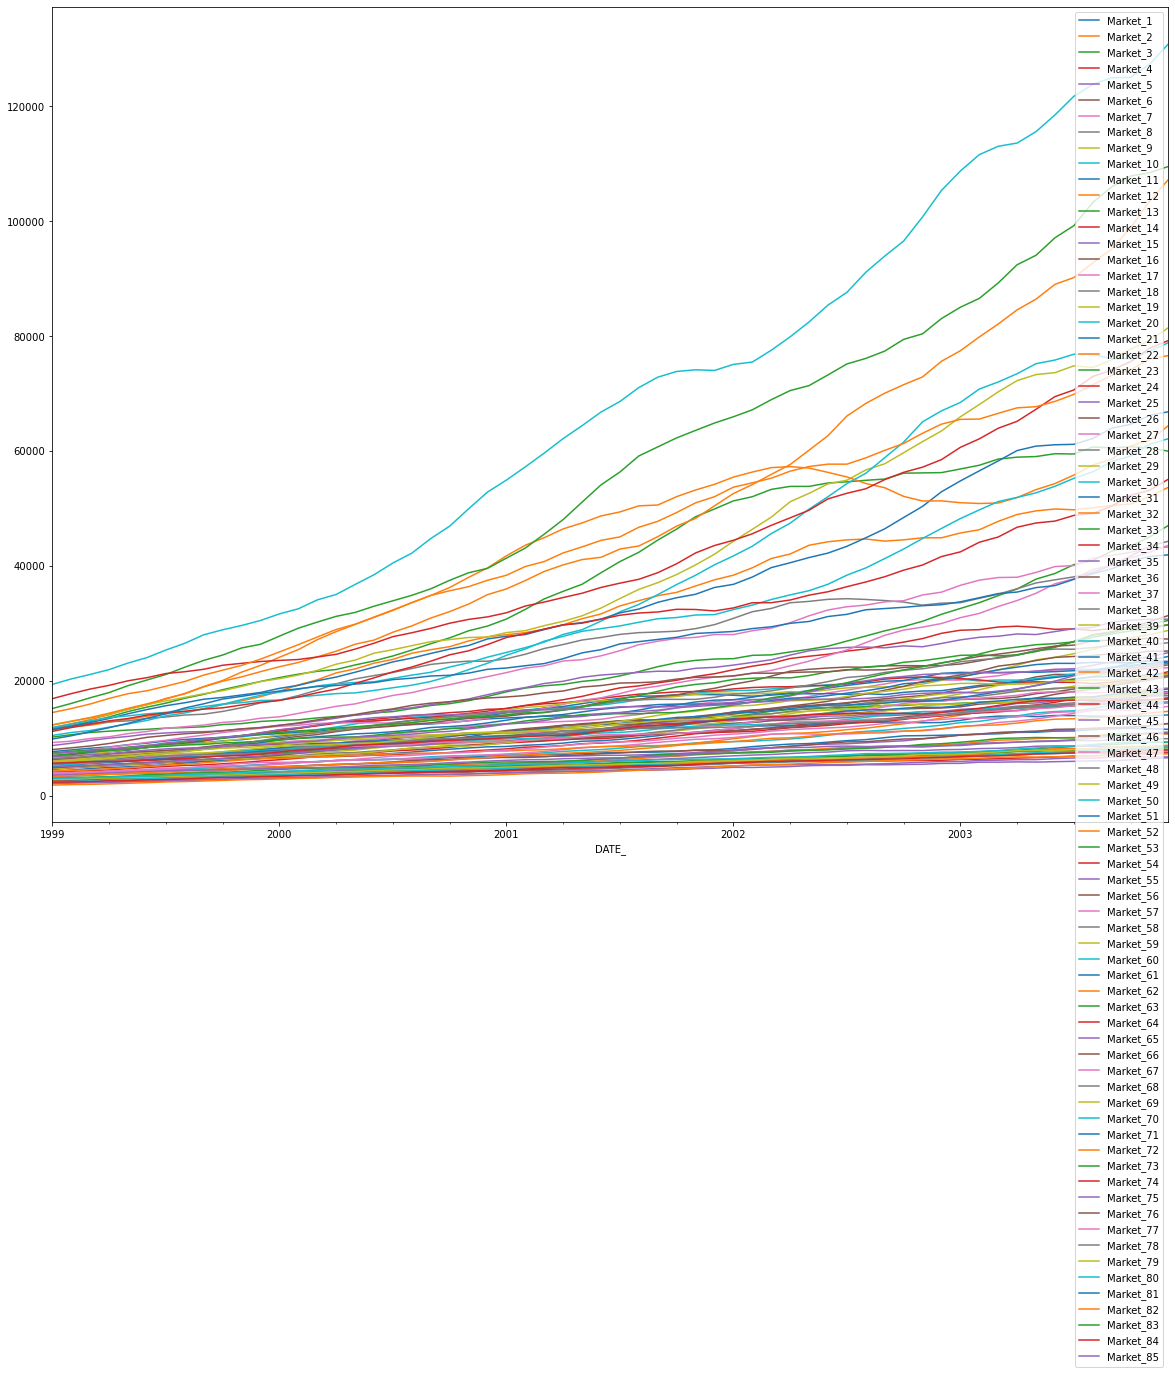

In [9]:
# plot Market_1 to market_5 after setting index to the DATE_ column
df_ts.set_index(key_ts)[['Market_{}'.format(x+1) for x in range(0,MarketMax)]].plot(figsize=(20,15));

In [10]:
# Locate the WML model
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "apikey": apikey['apikey'],
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}
wmlClient = APIClient(wml_credentials)
wmlClient.set.default_space(spaceID)

'SUCCESS'

In [11]:
wmlClient.deployments.get_details()['resources']

[{'entity': {'asset': {'id': '97944059-be88-48c6-87f0-59560af5d371'},
   'custom': {},
   'deployed_asset_type': 'model',
   'hardware_spec': {'id': 'Not_Applicable', 'name': 'S', 'num_nodes': 1},
   'name': 'Online_Market_Predict',
   'online': {},
   'space_id': 'd58d26ff-40c6-4e51-961b-71dabff4ab06',
   'status': {'online_url': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/1ea1ee5a-ab28-4e03-a1ff-126ee9446fa8/predictions'},
    'state': 'ready'}},
  'metadata': {'created_at': '2021-04-26T14:45:42.263Z',
   'id': '1ea1ee5a-ab28-4e03-a1ff-126ee9446fa8',
   'modified_at': '2021-04-26T14:45:42.263Z',
   'name': 'Online_Market_Predict',
   'owner': 'IBMid-270003266W',
   'space_id': 'd58d26ff-40c6-4e51-961b-71dabff4ab06'}},
 {'entity': {'asset': {'id': 'c540f382-21ff-435c-a6ee-4dc2252f840c'},
   'batch': {},
   'custom': {},
   'deployed_asset_type': 'model',
   'hybrid_pipeline_hardware_specs': [{'hardware_spec': {'id': 'c076e82c-b2a7-4d20-9c0f-1f0c2fdf5a24',
      'name'

In [12]:
# Find our model deployment
res=wmlClient.deployments.get_details()['resources']
depls=[x['entity'] for x in res if x['entity']['name']==TSModelName]
if len(depls)>0:
    depl=depls[0]
    print(f"Got deployment for model {TSModelName}")
else:
    print(f"Deployment with name {TSModelName} not found. Existing deployments: {','.join([x['entity']['name'] for x in res])}")

Got deployment for model Online_Market_Predict


In [13]:
# Get the model details
model=wmlClient.repository.get_model_details(depl['asset']['id'])

In [14]:
# Create a data frame structure that matches the model's 'input_data_schema'
input_columns=[x['name'] for x in model['entity']['schemas']['input'][0]['fields']]
df_ts=df_ts[input_columns]

In [15]:
# Extract input table as array of values suitable for WML invocation input
values_ts=[[str(e) for e in r] for r in df_ts.itertuples(index=False,name=None)]
print("predicting with {} lines as input".format(len(values_ts)))
payload_predict = {"input_data":[{"fields": input_columns, "values": values_ts}]}

predicting with 60 lines as input


In [17]:
# Score using the WML API
deplId=depl['status']['online_url']['url'].split('/')[-2]
predictions = wmlClient.deployments.score(deplId, payload_predict)

In [23]:
# Convert response back to dataframe
dfPredict=pd.DataFrame.from_records(predictions['predictions'][0]['values'],columns=predictions['predictions'][0]['fields'])
# Convert TS column
dfPredict[key_ts]=pd.to_datetime(dfPredict[key_ts],format="%Y-%m-%d %H:%M %p %Z")
dfPredict

,DATE_,$FutureFlag,Market_1,Market_2,Market_3,Market_4,Market_5,$TS-Market_1,$TSLCI-Market_1,$TSUCI-Market_1,...,$TSUCI-Market_3,$TSResidual-Market_3,$TS-Market_4,$TSLCI-Market_4,$TSUCI-Market_4,$TSResidual-Market_4,$TS-Market_5,$TSLCI-Market_5,$TSUCI-Market_5,$TSResidual-Market_5
0,1999-01-01 00:00:00+00:00,0,3750.179792,11488.581108,11658.795443,4571.338134,2205.463753,3818.937859,3636.351281,4001.524437,...,NaN,NaN,NaN,NaN,NaN,NaN,2209.676460,2097.535888,2321.817033,-4.212708
1,1999-02-01 00:00:00+00:00,0,3846.066274,11984.018649,12227.942408,4824.890057,2301.426550,3808.488227,3625.901650,3991.074805,...,NaN,NaN,4799.950128,4543.682021,5056.218234,24.939930,2276.620730,2164.480158,2388.761302,24.805820
2,1999-03-01 00:00:00+00:00,0,3894.418165,12265.668765,12896.507548,5040.973564,2352.200626,3915.580834,3732.994256,4098.167412,...,NaN,NaN,5067.498524,4855.391769,5279.605279,-26.524960,2367.519203,2255.378631,2479.659775,-15.318577
3,1999-04-01 00:00:00+00:00,0,4009.801974,12800.948326,13715.694537,5210.632898,2489.513496,3957.532470,3774.945893,4140.119048,...,NaN,NaN,5270.172158,5064.174215,5476.170101,-59.539260,2425.304878,2313.164306,2537.445451,64.208618
4,1999-05-01 00:00:00+00:00,0,4146.703036,13290.949737,14646.745863,5383.489476,2534.314453,4094.319639,3911.733061,4276.906216,...,NaN,NaN,5407.220920,5201.995726,5612.446114,-23.731444,2548.736827,2436.596254,2660.877399,-14.422374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2004-01-01 00:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,11503.302316,11320.715738,11685.888893,...,61060.009239,NaN,18235.498206,18058.049975,18412.946436,NaN,6655.708229,6543.567657,6767.848801,NaN
61,2004-02-01 00:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,11446.661431,11126.391594,11766.931267,...,62015.682654,NaN,18423.721626,18116.289063,18731.154190,NaN,6726.256772,6580.839756,6871.673788,NaN
62,2004-03-01 00:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,11390.020545,10909.727523,11870.313567,...,62908.089420,NaN,18628.493649,18136.046442,19120.940857,NaN,6796.805315,6624.391168,6969.219462,NaN
63,2004-04-01 00:00:00+00:00,1,NaN,NaN,NaN,NaN,NaN,11333.379660,10673.351783,11993.407537,...,63752.445278,NaN,18857.105642,18163.011977,19551.199308,NaN,6867.353858,6671.606311,7063.101406,NaN


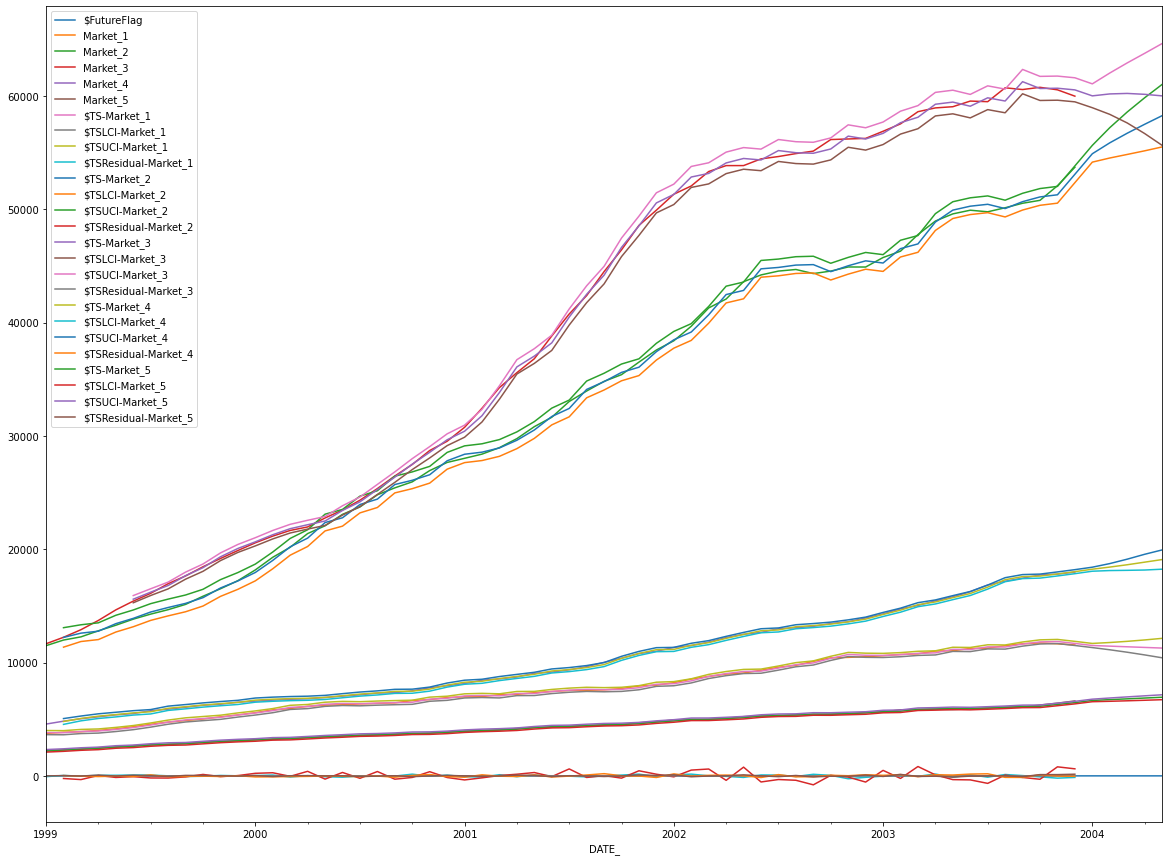

In [24]:
# Plot
dfPredict.set_index(key_ts).plot(figsize=(20,15));

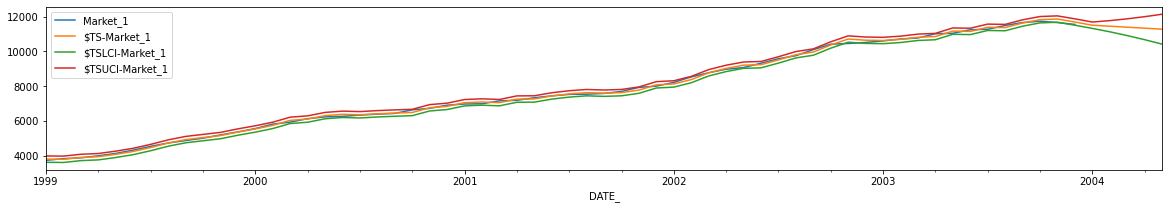

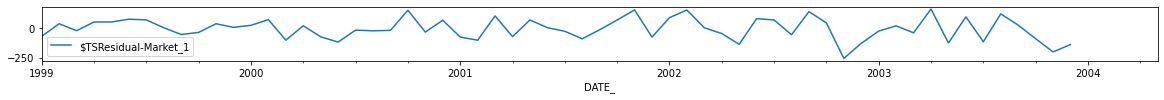

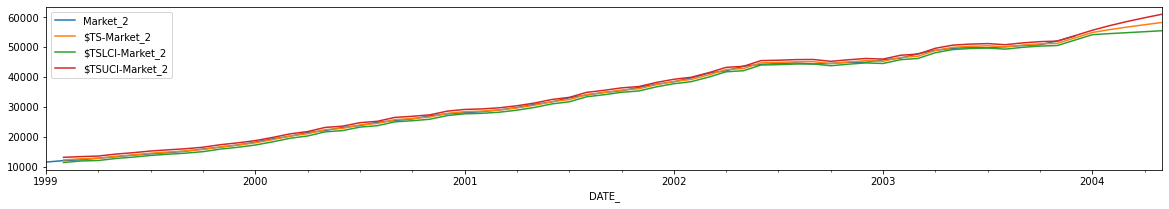

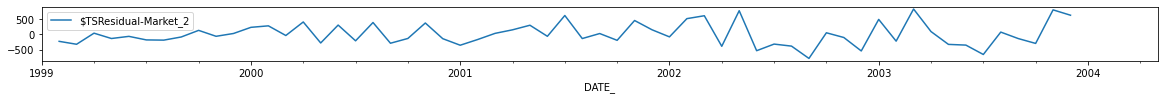

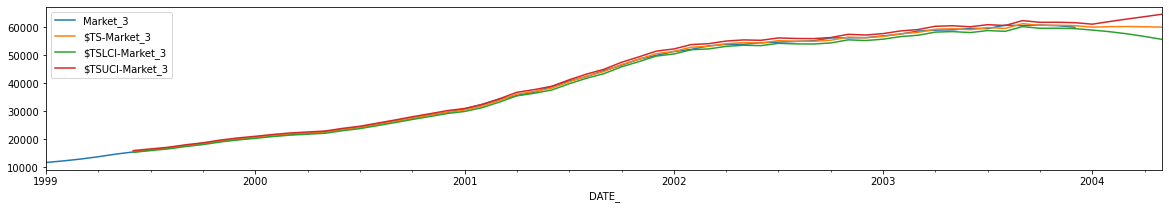

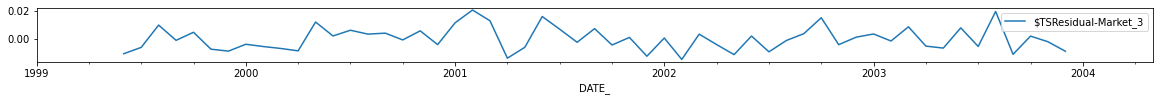

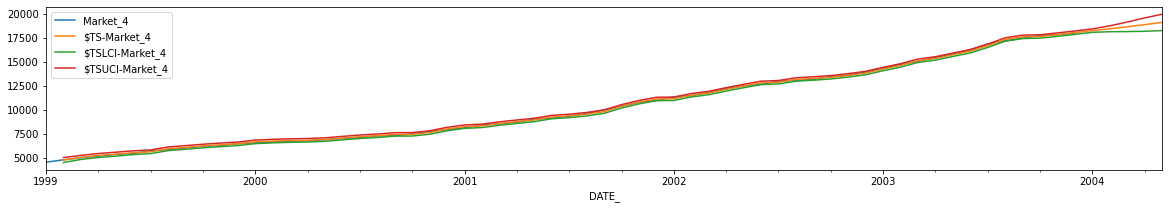

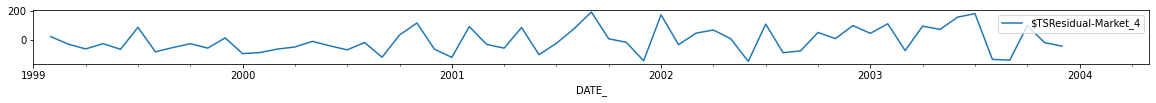

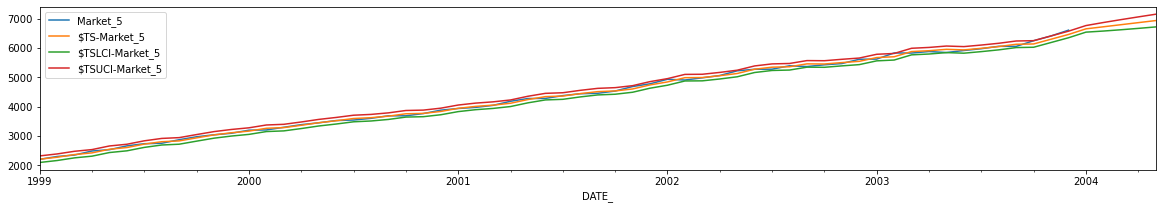

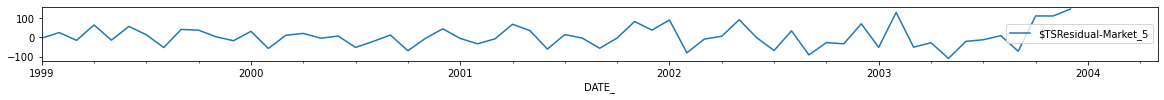

In [25]:
# plot each market
marketNum=4
for marketNum in range(1,6):
    marketCols=[key_ts]
    [marketCols.append(x) for x in dfPredict.columns if x.endswith('Market_{}'.format(marketNum)) and x.find("Residual")==-1]
    dfPredict[marketCols].set_index(key_ts).plot(figsize=(20,3));
    dfPredict[[key_ts,'$TSResidual-Market_{}'.format(marketNum)]].set_index(key_ts).plot(figsize=(20,1));